In [46]:
from stage1 import *

In [47]:
nframes,natoms,nmols=(0,0,0)

In [48]:
from stage2 import *

In [49]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [50]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [51]:
cf=condenseframe(testframe)

In [52]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [53]:
cf

array([[-0.87917119,  1.94185346,  1.82553874,  2.28225017,  0.95225006,
         1.95350003],
       [-0.83346242,  1.9462469 ,  1.83637778,  1.36549997,  1.45650005,
         2.59900022],
       [-0.90496299,  1.93660069,  1.80534572,  0.83375001,  1.77175009,
         0.73750007],
       ...,
       [-0.94544825,  1.97721459,  1.83950346,  2.56474996,  1.57500005,
         2.47574997],
       [-0.87788869,  1.99214553,  1.87599583,  1.61825013,  1.92200017,
         2.49900007],
       [-0.80652637,  1.98965405,  1.89646377,  0.79150009,  2.24175   ,
         2.16525006]])

In [54]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:03<00:00, 13.71it/s]

30192


In [55]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [56]:
g = get_graph(cf,1,n_neigh,"cry")

In [57]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [58]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 20
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [59]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

  0%|          | 0/30192 [00:00<?, ?it/s]

100%|██████████| 30192/30192 [00:00<00:00, 69320.81it/s]


In [60]:
graphs = graphs_device
total_graphs = len(graphs)


In [61]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cpu
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [62]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [63]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [64]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [65]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 42.9171
	Test: 	MSE Loss: 25.0141
Epoch: 002
	Train:	MSE Loss: 21.9975
	Test: 	MSE Loss: 21.1023
Epoch: 003
	Train:	MSE Loss: 20.8200
	Test: 	MSE Loss: 20.0633
Epoch: 004
	Train:	MSE Loss: 20.1404
	Test: 	MSE Loss: 19.8293
Epoch: 005
	Train:	MSE Loss: 19.8718
	Test: 	MSE Loss: 19.5598
Epoch: 006
	Train:	MSE Loss: 19.6511
	Test: 	MSE Loss: 19.3476
Epoch: 007
	Train:	MSE Loss: 19.4153
	Test: 	MSE Loss: 18.9624
Epoch: 008
	Train:	MSE Loss: 18.8266
	Test: 	MSE Loss: 18.2443
Epoch: 009
	Train:	MSE Loss: 18.0688
	Test: 	MSE Loss: 17.5007
Epoch: 010
	Train:	MSE Loss: 17.5553
	Test: 	MSE Loss: 17.1467
Epoch: 011
	Train:	MSE Loss: 17.3619
	Test: 	MSE Loss: 17.0280
Epoch: 012
	Train:	MSE Loss: 17.1900
	Test: 	MSE Loss: 16.9602
Epoch: 013
	Train:	MSE Loss: 17.0429
	Test: 	MSE Loss: 16.6667
Epoch: 014
	Train:	MSE Loss: 16.9016
	Test: 	MSE Loss: 16.7246
Epoch: 015
	Train:	MSE Loss: 16.7822
	Test: 	MSE Loss: 16.3932
Epoch: 016
	Train:	MSE Loss: 16.6422
	Test: 	MSE Loss: 

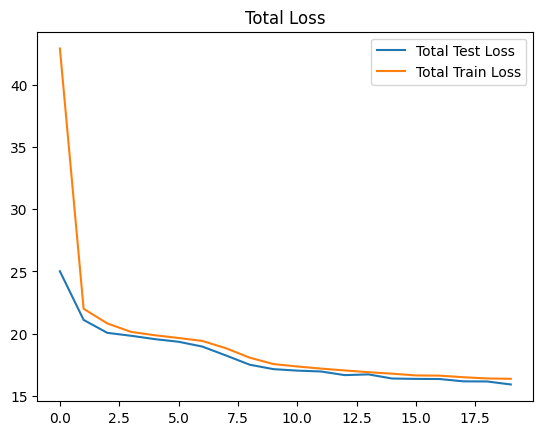

In [66]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

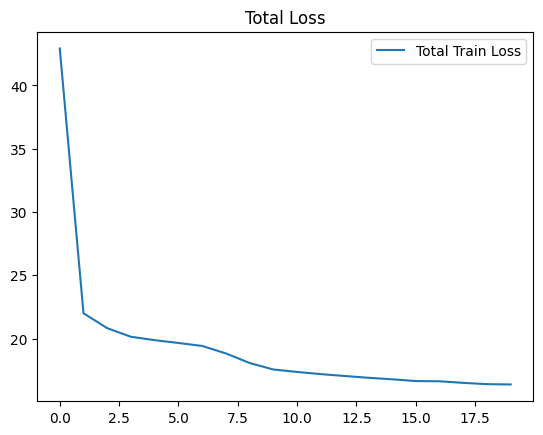

In [67]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

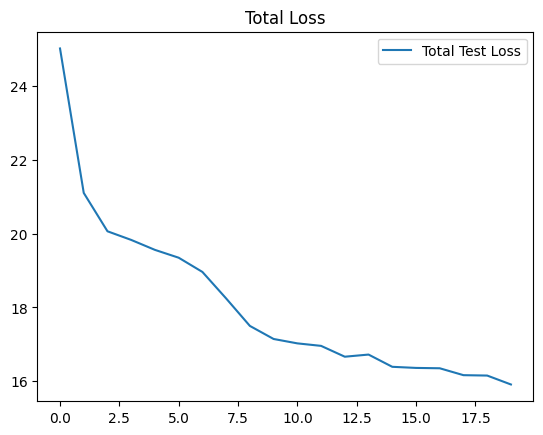

In [68]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [69]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()
    Error_total = F.mse_loss(decoded_x, test_graph.x).detach().cpu().numpy()


    avg1 += Error_wo_s
    avg2+= Error_total

print("Average Error", avg1/len(test_loader))
print("Average Error", avg2/len(test_loader))


Average Error 15.751158855903897
Average Error 16.00367785729105


In [70]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[1][heavy_indices])

21

In [71]:
input_feature[1]

tensor([[-0.3702,  1.8947,  1.9145, 24.6500, 20.4050, 10.2075],
        [-1.4548,  1.1401,  0.8651, 22.3525, 19.5175, 10.8775],
        [-0.9656,  1.1112,  0.9596, 26.0300, 18.2675,  9.7100],
        [-1.8368,  1.3585,  0.8061, 25.4325, 20.8025,  7.5425],
        [-1.8242,  1.1802,  0.7131, 25.8900, 22.7050, 11.3925],
        [-3.0915,  1.3079,  0.2722, 25.2850, 18.1225,  7.2875],
        [ 0.6673,  1.9240,  2.5482, 23.4475, 17.4200, 12.2200],
        [-1.4335,  1.7438,  1.3361, 21.3500, 22.1750, 10.8725],
        [-1.5181,  1.2846,  0.9534, 21.4350, 21.6550,  8.0250],
        [-0.1837,  2.0011,  2.1345, 23.7400, 23.9375, 12.0550],
        [-1.1372,  1.1819,  1.0354, 23.4075, 23.3750,  7.2850],
        [-2.3863,  1.3233,  0.5640, 20.1725, 18.3650,  9.8625],
        [-1.7973,  1.5524,  1.0590, 20.3200, 20.0075, 12.8800],
        [-3.1280,  1.2694,  0.2053, 23.5100, 15.5850,  8.8425],
        [-1.4064,  1.8074,  1.4163, 21.3650, 17.3200,  7.7225],
        [ 1.1587,  1.8816,  2.6877, 24.8

In [72]:
input_feature[20][heavy_indices]

tensor([[-1.3114,  1.8690,  1.5039, 12.0575, 23.0025, 11.7525],
        [-1.7856,  1.1053,  0.6481, 11.2300, 23.4475, 14.2925],
        [-1.0329,  1.9109,  1.7131, 13.1575, 21.1225,  9.8750],
        [-0.0301,  1.8506,  2.1237, 13.9925, 23.9475, 13.9525],
        [-1.9860,  1.2843,  0.6596, 10.0175, 25.2200, 12.4725],
        [-1.1372,  1.1017,  0.9082, 10.8725, 25.4125,  9.8150],
        [-2.6382,  1.2584,  0.3758, 13.9275, 20.3325, 12.8125],
        [-1.3431,  1.8634,  1.4889, 10.9575, 19.9450, 13.1725],
        [-0.1124,  1.3547,  1.5391, 13.4400, 24.4225,  8.7525],
        [ 0.4116,  1.5446,  1.9648, 15.6900, 22.1225, 11.1475],
        [-2.5678,  1.2353,  0.3958,  8.9075, 22.7375,  9.6275],
        [-2.5250,  1.3823,  0.5272, 11.3325, 23.3100,  7.9675],
        [-2.3404,  1.2055,  0.5009,  8.9900, 20.6600, 11.2550],
        [-1.5777,  1.8129,  1.4495, 15.0275, 22.4575,  7.8625],
        [-0.2141,  1.4157,  1.6443,  7.2825, 24.1600, 12.3900],
        [ 0.2147,  1.3706,  1.7396,  9.2

In [73]:
decoded_feature[20][heavy_indices]

tensor([[-0.8008,  1.6752,  1.5266, 15.2867, 13.5244, 10.6346],
        [-0.8916,  1.5836,  1.5125, 18.3582, 15.8992,  9.8320],
        [-0.8995,  1.5818,  1.5096, 18.7317, 16.1747,  9.2545],
        [-0.8965,  1.5837,  1.5096, 18.5819, 16.0671,  9.5053],
        [-0.8952,  1.5837,  1.5104, 18.5239, 16.0236,  9.5912],
        [-0.8888,  1.6026,  1.5190, 18.8031, 16.2912,  7.5055],
        [-0.8963,  1.5837,  1.5098, 18.5730, 16.0604,  9.5184],
        [-0.8890,  1.6027,  1.5189, 18.8072, 16.2937,  7.5104],
        [-0.8951,  1.5838,  1.5105, 18.5197, 16.0205,  9.5974],
        [-0.8891,  1.6027,  1.5188, 18.8096, 16.2952,  7.5133],
        [-0.8991,  1.5822,  1.5096, 18.7135, 16.1620,  9.2870],
        [-0.8961,  1.5837,  1.5099, 18.5657, 16.0550,  9.5293],
        [-0.8958,  1.5837,  1.5101, 18.5502, 16.0433,  9.5522],
        [-0.8931,  1.5837,  1.5116, 18.4287, 15.9521,  9.7295],
        [-0.8971,  1.5837,  1.5092, 18.6102, 16.0882,  9.4625],
        [-0.9007,  1.5825,  1.5104, 18.7

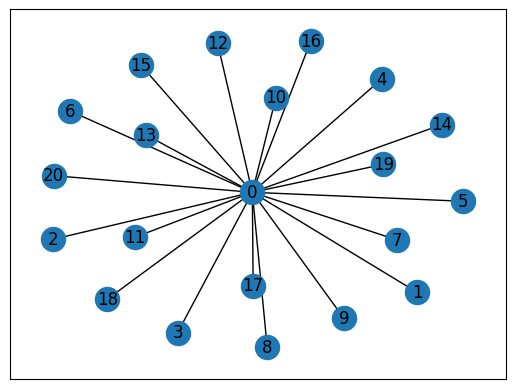

In [74]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [75]:
def plotCompare(features1,features2):
    # %matplotlib widget
    xyz1 = features1[:,-3:]
    xyz2 = features2[:,-3:]
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(xyz1[:,0],xyz1[:,1],xyz1[:,2],label="output")
    ax1.scatter(xyz2[:,0],xyz2[:,1],xyz2[:,2],label="input")
    plt.legend()
    plt.show()

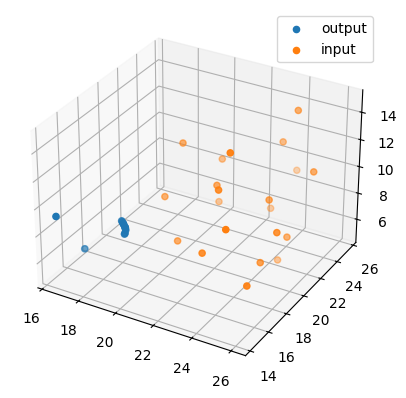

In [76]:
plotCompare(decoded_feature[1].detach().numpy(),input_feature[1].detach().numpy())


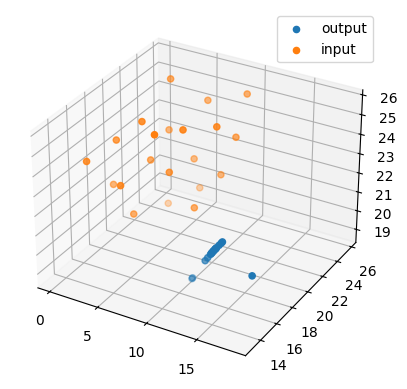

In [77]:
plotCompare(decoded_feature[15].detach().numpy(),input_feature[15].detach().numpy())

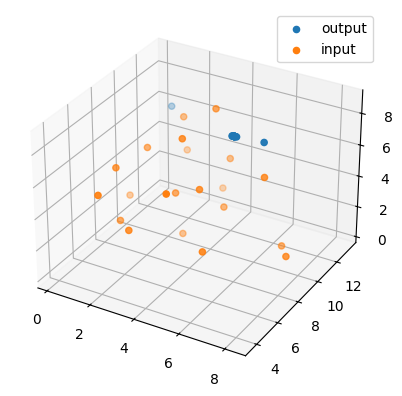

In [78]:
plotCompare(decoded_feature[39].detach().numpy(),input_feature[39].detach().numpy())